# A Game of Words

<a id = 'toc'></a>
## Table of Contents
1. [Load & Import Data](#load_and_import)
2. [Vectorize Input](#vectorize)
3. [Batch and Prefetch](#batch_and_prefetch)
4. [Generate Training Data](#generate_data)
5. [Word2Vec](#word_vec)
6. [Visualize Word Embeddings](#visualize)

<a id = 'load_and_import'></a>
### [Load & Import Data](#toc)

> `Sumerians invented the wheel. I'd much rather just use it.`

In [1]:
import io
import numpy as np
import os
import string
from tqdm import tqdm
import re
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Dot, Embedding, Flatten, Reshape
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import pathlib
from sklearn.manifold import TSNE
from tensorboard.plugins import projector

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_dir = pathlib.Path(os.getcwd())
data_dir = base_dir / 'Data'
train_file = [file for file in pathlib.Path.glob(data_dir, pattern = '*train.tokens')][0]
test_file = [file for file in pathlib.Path.glob(data_dir, pattern = '*test.tokens')][0]
valid_file = [file for file in pathlib.Path.glob(data_dir, pattern = '*valid.tokens')][0]

In [3]:
with open(train_file, encoding = 'UTF-8') as f:
    lines1 = f.read().splitlines()

with open(test_file, encoding = 'UTF-8') as f:
    lines2 = f.read().splitlines()

with open(test_file, encoding = 'UTF-8') as f:
    lines3 = f.read().splitlines()

lines = list(np.concatenate((np.concatenate((lines1, lines2), axis = 0), lines3), axis = 0))

In [5]:
text_ds = tf.data.TextLineDataset([train_file, test_file, valid_file]).filter(lambda x:tf.cast(tf.strings.length(x), bool))
text_ds = text_ds.filter(lambda x: tf.cast(x != b' ', bool))

In [6]:
sentences = list(text_ds.as_numpy_iterator())
print(len(sentences))

29119


In [7]:
for stc in sentences[:5]:
    print(stc)

b' = Valkyria Chronicles III = '
b' Senj\xc5\x8d no Valkyria 3 : <unk> Chronicles ( Japanese : \xe6\x88\xa6\xe5\xa0\xb4\xe3\x81\xae\xe3\x83\xb4\xe3\x82\xa1\xe3\x83\xab\xe3\x82\xad\xe3\x83\xa5\xe3\x83\xaa\xe3\x82\xa23 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . '
b" The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard feature

<a id = 'vectorize'></a>
### [Vectorize Input](#toc)

In [8]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    text = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')
    return tf.strings.regex_replace(text, 'unk', "[UNK]")

vocab_size = 10000
sequence_length = 10
vectorize_layer = TextVectorization(standardize = custom_standardization,
                                   max_tokens = vocab_size,
                                   output_mode = 'int',
                                   output_sequence_length = sequence_length)

vectorize_layer.adapt(text_ds.batch(1024))
inverse_vocab = vectorize_layer.get_vocabulary()
print(len(inverse_vocab))
print(inverse_vocab[:20])

10000
['', '[UNK]', 'the', 'of', 'and', 'in', 'to', 'a', 'was', 'on', 'as', 's', 'that', 'for', 'with', 'by', 'is', 'at', 'from', 'it']


<a id = 'batch_and_prefetch'></a>
### [Batch and Prefetch](#toc)

In [9]:
text_vector_ds = text_ds.batch(1024).prefetch(tf.data.AUTOTUNE).map(vectorize_layer).unbatch()

sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

for seq in sequences[:5]:
    print(f'{seq} => {[inverse_vocab[i] for i in seq]}')

29119
[4795 4207  969    0    0    0    0    0    0    0] => ['valkyria', 'chronicles', 'iii', '', '', '', '', '', '', '']
[   1   76 4795   81    1 4207  430    1    0    0] => ['[UNK]', 'no', 'valkyria', '3', '[UNK]', 'chronicles', 'japanese', '[UNK]', '', '']
[   2   64  127  365    5  283 2738   58    7  169] => ['the', 'game', 'began', 'development', 'in', '2010', 'carrying', 'over', 'a', 'large']
[  19  788   14  927 1614    5  739    4    8  731] => ['it', 'met', 'with', 'positive', 'sales', 'in', 'japan', 'and', 'was', 'praised']
[2199    0    0    0    0    0    0    0    0    0] => ['gameplay', '', '', '', '', '', '', '', '', '']


In [10]:
vocab = {}
for index, token in enumerate(inverse_vocab):
    vocab[token] = index
    
print(len(vocab))

10000


In [11]:
sentence = 'I am valkyria and am working as a machine learning with'
tokens = list(sentence.lower().split())
example_sequence = [vocab[word] for word in tokens]
print(example_sequence)

[59, 1610, 4795, 4, 1610, 652, 10, 7, 1021, 2952, 14]


In [12]:
window_size = 2
positive_skip_grams = tf.keras.preprocessing.sequence.skipgrams(example_sequence,
                                                                vocabulary_size = vocab_size,
                                                                window_size = window_size,
                                                                negative_samples=0)

print(len(positive_skip_grams))
for target, context in positive_skip_grams[0]:
    print(f'({target}, {context}): ({inverse_vocab[target]}, {inverse_vocab[context]})')

2
(652, 7): (working, a)
(1610, 10): (am, as)
(1610, 59): (am, i)
(1021, 14): (machine, with)
(1610, 652): (am, working)
(1610, 4795): (am, valkyria)
(4795, 1610): (valkyria, am)
(59, 1610): (i, am)
(4, 1610): (and, am)
(1021, 7): (machine, a)
(652, 10): (working, as)
(14, 2952): (with, learning)
(1021, 2952): (machine, learning)
(7, 10): (a, as)
(7, 652): (a, working)
(652, 1610): (working, am)
(1610, 4795): (am, valkyria)
(2952, 7): (learning, a)
(4, 652): (and, working)
(10, 1021): (as, machine)
(2952, 14): (learning, with)
(4795, 59): (valkyria, i)
(59, 4795): (i, valkyria)
(4795, 1610): (valkyria, am)
(1610, 4): (am, and)
(4795, 4): (valkyria, and)
(10, 652): (as, working)
(4, 1610): (and, am)
(652, 4): (working, and)
(14, 1021): (with, machine)
(2952, 1021): (learning, machine)
(10, 7): (as, a)
(10, 1610): (as, am)
(1610, 4): (am, and)
(7, 1021): (a, machine)
(4, 4795): (and, valkyria)
(1021, 10): (machine, as)
(7, 2952): (a, learning)


<a id = 'generate_data'></a>
### [Generate Training Data](#toc)

In [13]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    targets, contexts, labels = [], [], []
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
    for sequence in tqdm(sequences):
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(sequence,
                                                                           vocabulary_size= vocab_size,
                                                                           sampling_table = sampling_table,
                                                                           window_size = window_size,
                                                                           negative_samples = 0)
        if len(positive_skip_grams) != 0:
            for target_word, context_word in positive_skip_grams:
                context_class = tf.expand_dims(tf.constant([context_word], dtype = 'int64'), 1)
                negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(true_classes = context_class,
                                                                                             num_true = 1,
                                                                                             num_sampled = num_ns,
                                                                                             unique = True,
                                                                                             range_max = vocab_size,
                                                                                             seed = seed,
                                                                                             name = 'negative_sampling')
                negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates,
                                                             1)
                context = tf.concat([context_class, negative_sampling_candidates], 0)
                label = tf.constant([1] + list(np.repeat(0, num_ns)), dtype = 'int64')
                targets.append(target_word)
                contexts.append(context)
                labels.append(label)
    return targets, contexts, labels

In [14]:
SEED = 123
targets, contexts, labels = generate_training_data(sequences = sequences,
                                                  window_size = 2,
                                                  num_ns = 4,
                                                  vocab_size = vocab_size,
                                                  seed = SEED)

100%|███████████████████████████████████████████████████████████████████████████| 29119/29119 [01:47<00:00, 271.37it/s]


In [15]:
print(len(targets), len(contexts), len(labels))

138093 138093 138093


In [16]:
print("target | context | label")
for target, context, label in zip(targets[:5], contexts[:5], labels[:5]):
    print(f"{target} | {context} | {label}")
    print("-"*80)

target | context | label
4795 | [[969]
 [ 19]
 [865]
 [429]
 [133]] | [1 0 0 0 0]
--------------------------------------------------------------------------------
4795 | [[4207]
 [  17]
 [   6]
 [   9]
 [   4]] | [1 0 0 0 0]
--------------------------------------------------------------------------------
4207 | [[4795]
 [  15]
 [ 786]
 [  11]
 [  12]] | [1 0 0 0 0]
--------------------------------------------------------------------------------
4207 | [[969]
 [ 78]
 [  9]
 [174]
 [204]] | [1 0 0 0 0]
--------------------------------------------------------------------------------
4207 | [[   1]
 [1939]
 [  98]
 [  37]
 [  26]] | [1 0 0 0 0]
--------------------------------------------------------------------------------


<a id = 'word_vec'></a>
### [Word2Vec](#toc)

In [17]:
class Word2Vec(Model):
    def __init__(self, vocab_size, embedding_dim, num_ns, vocabulary):
        super(Word2Vec, self).__init__()
        self.vocabulary = vocabulary
        self.target_embedding = Embedding(vocab_size,
                                          embedding_dim,
                                          input_length = 1,
                                          name = "w2v_embedding")
        self.context_embedding = Embedding(vocab_size,
                                          embedding_dim,
                                          input_length = num_ns + 1)
        self.dots = Dot(axes = (3,2))
        self.flatten = Flatten()
    def call(self, pair):
        target, context = pair
        we = self.target_embedding(target)
        ce = self.context_embedding(context)
        dots = self.dots([ce, we])
        return self.flatten(dots)

In [18]:
num_ns = 4
embedding_dim = 256
word2vec = Word2Vec(vocab_size, embedding_dim, num_ns, vectorize_layer.get_vocabulary())
word2vec.compile(optimizer = 'adam', loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True))

In [19]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True)
print(dataset)

<BatchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>


In [20]:
dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)
print(dataset)

<PrefetchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>


In [21]:
history = word2vec.fit(dataset, epochs = 35)

Epoch 1/35
134/134 [==============================] - 3s 13ms/step - loss: 1.5994
Epoch 2/35
134/134 [==============================] - 2s 13ms/step - loss: 1.4705
Epoch 3/35
134/134 [==============================] - 2s 12ms/step - loss: 1.2981
Epoch 4/35
134/134 [==============================] - 2s 13ms/step - loss: 1.1317
Epoch 5/35
134/134 [==============================] - 2s 13ms/step - loss: 0.9733
Epoch 6/35
134/134 [==============================] - 2s 12ms/step - loss: 0.8305
Epoch 7/35
134/134 [==============================] - 2s 12ms/step - loss: 0.7057: 0s - loss: 0.
Epoch 8/35
134/134 [==============================] - 2s 12ms/step - loss: 0.5988
Epoch 9/35
134/134 [==============================] - 2s 12ms/step - loss: 0.5091
Epoch 10/35
134/134 [==============================] - 2s 12ms/step - loss: 0.4349
Epoch 11/35
134/134 [==============================] - 2s 12ms/step - loss: 0.3740
Epoch 12/35
134/134 [==============================] - 2s 12ms/step - loss: 0.324

In [22]:
word_vec = word2vec.get_layer('w2v_embedding').get_weights()[0]
word_vec = np.asarray(word_vec, dtype = 'float32')

In [23]:
vocab = vectorize_layer.get_vocabulary()

In [24]:
out_v = io.open('./Results/vectors.tsv', 'w', encoding = 'UTF-8')
out_m = io.open('./Results/metadata.tsv', 'w', encoding = 'UTF-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue
    vec = word_vec[index]
    out_v.write('\t'.join([str(x) for x in vec]))
    out_m.write(str(index) + "\t" + word + '\n')
out_v.close()
out_m.close()

Now go to <a href = 'https://projector.tensorflow.org/'>Embedding Projector</a>

In [25]:
log_dir = './Results'
weights = tf.Variable(word2vec.get_layer('w2v_embedding').get_weights()[0][1:])
checkpoint = tf.train.Checkpoint(embedding = weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = './Results/metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [27]:
%load_ext tensorboard
%tensorboard --logdir './Results'

<a id = 'visualize'></a>
### [Visualize Word Embeddings](#toc)

  0%|                                                                                          | 0/199 [00:00<?, ?it/s]<ipython-input-103-0abe785b0b06>:26: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(labels[i],
100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 268.54it/s]


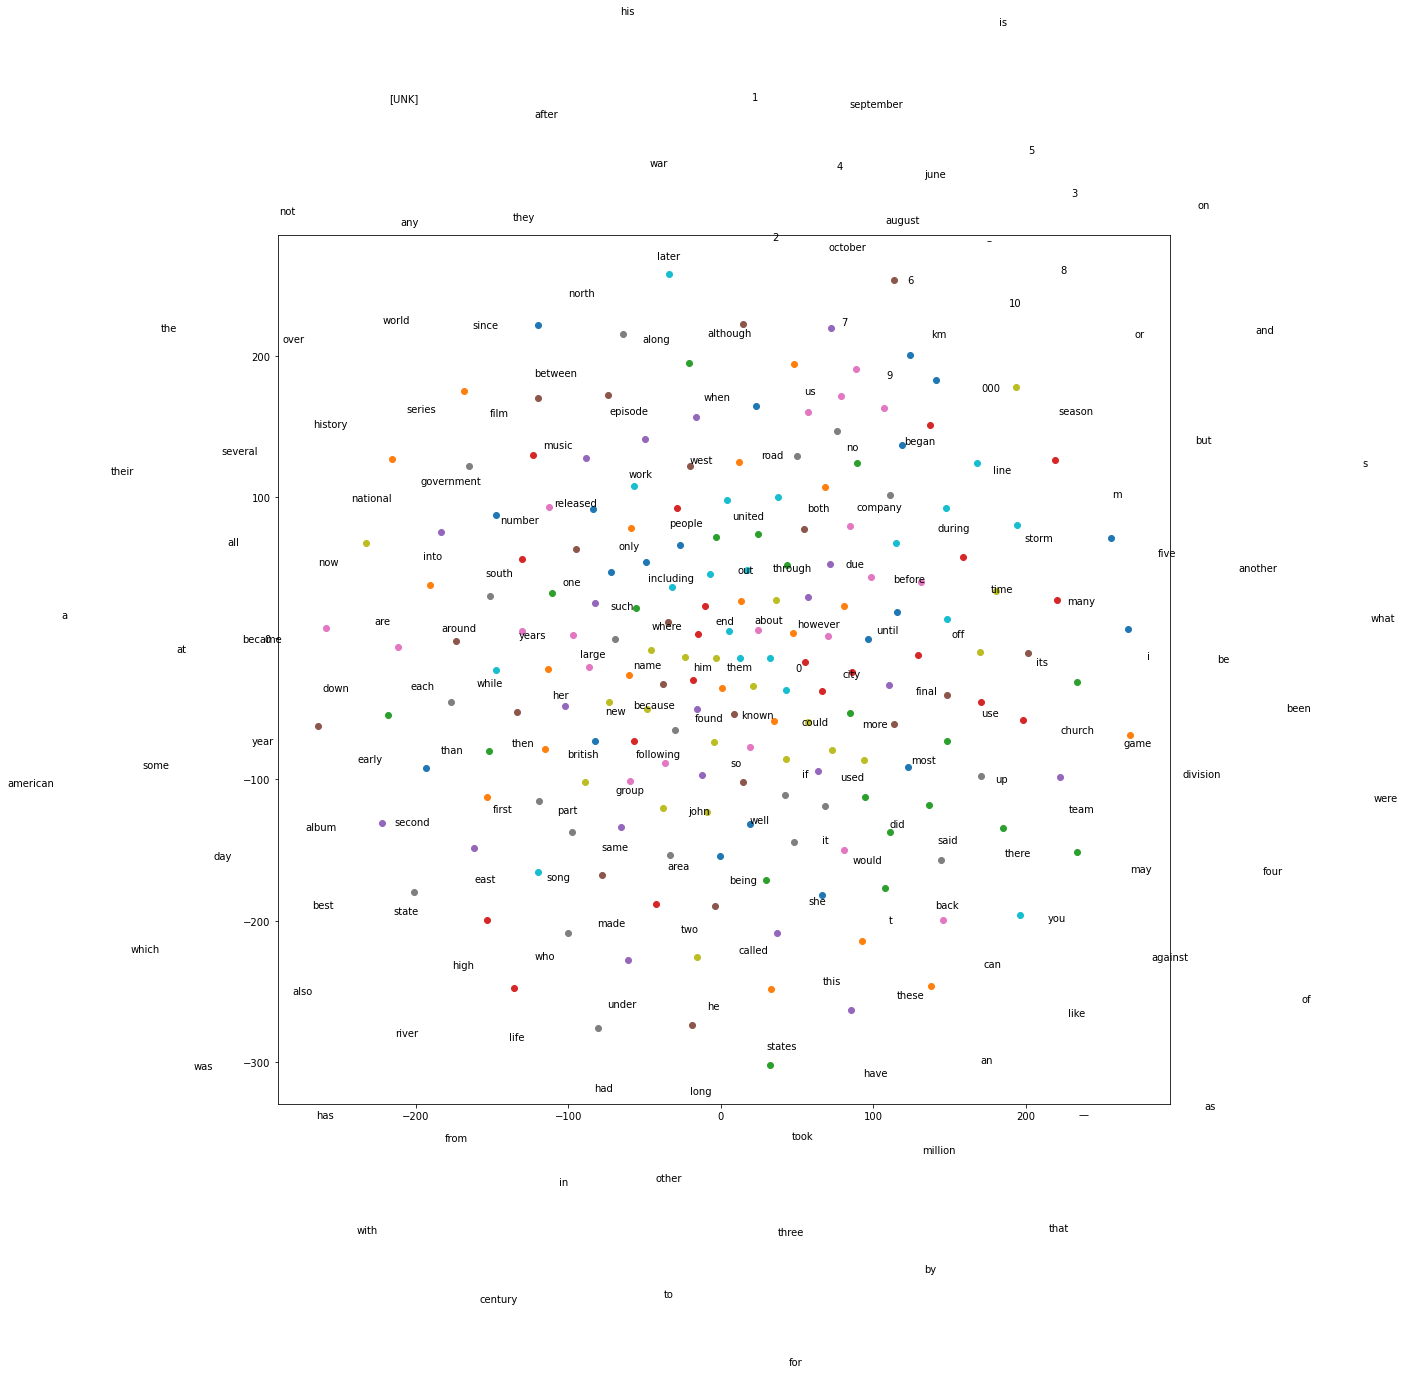

In [103]:
from sklearn.manifold import TSNE
word_vectors = []
labels = []
for index, word in enumerate(vocab[:200]):
    if index == 0:
        continue
    vec = word_vec[index]
    label = word
    word_vectors.append(vec)
    labels.append(label)
    tsne_model = TSNE(perplexity = 40,
                     n_components = 2,
                     init = 'pca',
                     n_iter = 2500,
                     random_state = 123)
new_values = tsne_model.fit_transform(word_vectors)
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize = (16,16))
for i in tqdm(range(len(x))):
    plt.scatter(x[i], y[i])
    plt.annotate(labels[i],
                xy = (x[i], y[i]),
                textcoords = 'offset points',
                ha = 'right',
                va = 'bottom')
plt.show()